We consider a pure exchange economy with $M$ agents and $n$ commodities.
Each agent $i$ has an endowment $e_i \in {\bf{R}}_+^n$ and a utility 
function $U_i(r_i)$, where $U_i: {\bf{R}}_+^n \to {\bf{R}}$ is a concave nondecreasing. These primitives define the exchange economy $\mathcal{E}=\left( (U_i, e_i)_{i \in [M]}\right)$. Denote the total endowment by $E = \sum_{i=1}^M e_i$.


**Walrasian equilibrium** for exchange economy $\mathcal{E}$ is a vector $\left( \nu, (x_i)_{i \in [M]}\right)$, such that 
* every agent's consumption  $x_i\in {\bf{R}}^n$ maximizes her utility given prices $\nu \in {\bf{R}}_+^n$
$$
\begin{array}{ll}
\mbox{maximize} & U_i(x_i)  \\
\mbox{subject to} & \nu^T x_i \leq \nu^T e_i \\
& x_i \geq  0,
\end{array}
$$
* markets clear $\sum_{i=1}^M x_i \leq \sum_{i=1}^M e_i=E$.

The goal of this notebook is to see the performance of OSBDO when applied to the action directed Walrasian Equilibrium (over primal variables $x_1, \ldots, x_M$) and price directed Walrasian Equilibrium (over dual variable $\nu$). This corresponds to the primal formulation of the problem, given by
$$
\begin{array}{ll}
\mbox{minimize} & \sum_{i=1}^M -U_i(x_i)  \\
\mbox{subject to} & \sum_{i=1}^M x_i = E \\
& x_i  \geq 0, \quad i=1,\ldots, M,
\end{array}
$$
and negated dual formulation of the problem, given by  
$$
\begin{array}{ll}
\mbox{minimize} & \sum_{i=1}^M \underset{x_i\geq 0}{\max} \left(
 U_i(x_i) - \nu_i^Tx_i 
\right ) + \nu_1^T E   \\
\mbox{subject to} & \nu_1=\cdots=\nu_M.
\end{array}
$$


In [1]:
import cvxpy as cp
import numpy as np
import osbdo as ob
import random

from scipy import stats
import time
from scipy import stats

In [2]:
import matplotlib.pyplot as plt

In [3]:
def get_rel_diff(a,b):
    return np.linalg.norm(a-b) / min(np.linalg.norm(a), np.linalg.norm(b)) 

In [4]:
def check_subgrads(agent, ntimes):
    l, u = agent.lwb, agent.upb
    n = agent.dim
    for _ in range(ntimes):
        v = l + np.multiply(np.random.rand(n), u-l)
        point = agent.query(v=v)
        linear = lambda x: point.f + point.q @ (x - point.x)
        for _ in range(10):
            test = l + np.multiply(np.random.rand(n), u-l)
            a = linear(test)
            b = agent.query(v=test).f + 10**(-6)
            assert a <= b, print(a, b, b-a)
    print("passed")

# Create instance of the problem

In [5]:
# fix seed for reproducibility
np.random.rand(1001)
random.seed(1001)

In [6]:
M = 50

params, R = ob.ra_params(num_resources=M, num_agents=M, num_participants=M)

In [7]:
E = R
n = params[0]['dimension']

In [8]:
for j in range(n):
    count = 0
    for i in range(M):
        A = params[i]["A_list"][0]
        if A[0,j] > 0:
            count += 1
    assert count > 0

# Centralized solution

In [9]:
dim = params[0]['dimension']
z = cp.Variable(len(params)*dim)
num_agents = len(params)
constraints = []
f = 0
xi_list = []
start = time.time()
for i in range(num_agents):
    xi = z[(i*dim):((i+1)*dim)]
    X = cp.Variable((len(params[i]['A_list']), dim))
    for j in range(len(params[i]['A_list'])):
        f += -cp.geo_mean(params[i]['A_list'][j] @ X[j].T + params[i]['b_list'][j])
    constraints += [cp.sum(X,axis=0) <= xi, \
                    X>=0, \
                    xi<=params[i]['upper_bound'], 
                    xi>=params[i]['lower_bound']]
    xi_list.append(xi)
constraints += [sum(xi_list)==R]
prob_cvx = cp.Problem(cp.Minimize(f), constraints)
prob_cvx.solve(solver='ECOS')
print(f"elapsed time =  {time.time()-start}")

h_cvx, x_cvx = f.value, z.value
nu_cvx = constraints[-1].dual_value
print(f"{h_cvx = }")

elapsed time =  1.9086570739746094
h_cvx = -385.98249200224524


### Initial upper bound on $\nu$
$$
\nu^\star_j \leq \nu_{\max,j} ~=~ \min_{i:{A_{i, \cdot j}}\neq 0 } \quad \left [ (1/m) \mbox{geomean}(A_i E + b_i) ~ A_i^T b_i^{-1} \right ]
$$

In [10]:
nu_upb = np.inf * np.ones(n)
m = params[0]["A_list"][0].shape[0]

for i  in  range(M):
    A = params[i]["A_list"][0]
    b = params[i]["b_list"][0]
    assert (A>=0).all() and (b>=0).all()
    Ui = stats.mstats.gmean(A@E + b)
    grad_i = (Ui/m) * A.T @ b**(-1)
    
    for j in range(n):
        if A[0,j] > 0:
            nu_upb[j] = min(nu_upb[j], grad_i[j])

In [11]:
nu_cvx.min(), nu_cvx.max(), nu_upb.min(), nu_upb.max()

(0.6719435124682612, 0.9362098681037011, 4.393557631961159, 27.033962137851475)

In [12]:
assert (nu_cvx <= nu_upb + 10**(-8) ).all(), print("wrong bound on nu")

# Action directed Walrasian equilibrium
$$
\begin{array}{ll}
\mbox{minimize} & \sum_{i=1}^M -U_i(x_i)  \\
\mbox{subject to} & \sum_{i=1}^M x_i = E \\
& x_i  \geq 0, \quad i=1,\ldots, M,
\end{array}
$$
where $U_i(x_i)= \left (\prod_{k=1}^m (A_{i,k}x_{i} + b_{i,k})\right)^{1/m}$.

## OSBDO oracle-structured form 
We can solve the problem using OSBDO, by taking the agent function
$$
f_i(x_i) = -U_i(x_i),$$
and the structured objective function $g$,
$$
g(x) = \left\{ \begin{array}{ll} 0 &
x_1 + \cdots + x_M = E, \quad x_i \geq 0, \quad i=1, \ldots, M\\
\infty & \mbox{otherwise}.
\end{array} \right.
$$

In [13]:
rel_gap = 0.01

# OSBDO solution

In [14]:
agents = ob.ra_agents(params=params)

domain = [sum([agents[i].x for i in range(len(agents))])==R]
g = ob.Coupling(agents = agents, function = cp.Constant(0), domain = domain)

prob = ob.Problem(agents = agents, g = g)

In [15]:
start = time.time()
x_agent, x_global = prob.solve(rel_gap=rel_gap, abs_gap=10**(-3), max_iter=50)
print(f"elapsed time =  {time.time()-start}")

k=0, rel_gap=28.831944548725165, L=-8210.58720837844, U=-275.22802594942846
k=1, rel_gap=0.4397526002615963, L=-396.2602660255557, U=-275.22802594942846
k=2, rel_gap=0.1783503150641179, L=-393.55716495570067, U=-333.9899518203005
k=3, rel_gap=0.09148279561102253, L=-393.0767514662602, U=-360.13096408561535
k=4, rel_gap=0.057592313173734436, L=-392.75915921187425, U=-371.3710418651221
k=5, rel_gap=0.04494809511357782, L=-392.64529789778527, U=-375.7557908702707


/Users/parshakova.tanya/opt/anaconda3/envs/py38/lib/python3.8/site-packages/cvxpy/problems/problem.py:1333: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


k=6, rel_gap=0.035492885476298336, L=-390.67718747834385, U=-377.286211192695
k=7, rel_gap=0.02370395718872496, L=-388.3012763823935, U=-379.31012540846143
k=8, rel_gap=0.01708723649302611, L=-388.2464137895395, U=-381.72380879366347
k=9, rel_gap=0.014913835673589103, L=-388.2056573832333, U=-382.5010988500169
k=10, rel_gap=0.011152736395849513, L=-386.9393012981778, U=-382.6714672971992
k=11, rel_gap=0.007624467165450513, L=-386.9203101604063, U=-383.99257140792963
elapsed time =  96.8302550315857


# $L^k, \quad h^\star, \quad U^k$

In [16]:
prob.lower_bnd[-1], h_cvx, prob.upper_bnd[-1]

(-386.9203101604063, -385.98249200224524, -383.99257140792963)

## Plot

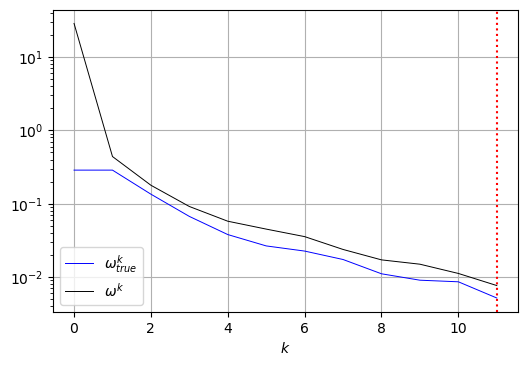

In [17]:
ob.plot_true_rel_gap_uk(lk = prob.lower_bnd, uk = prob.upper_bnd, h_true = h_cvx)

# Price directed Walrasian equilibrium
$$
\begin{array}{ll}
\mbox{minimize} & \sum_{i=1}^M \underset{x_i\geq 0}{\max} \left(
 U_i(x_i) - \nu_i^Tx_i 
\right ) + \nu_1^T E   \\
\mbox{subject to} & \nu_1=\cdots=\nu_M,
\end{array}
$$
where $U_i(x_i)= \left (\prod_{k=1}^m (A_{i,k}x_{i} + b_{i,k})\right)^{1/m}$.

## OSBDO oracle-structured form 

We can solve the problem in the dual variable using OSBDO, by taking the agent function
$$
f_i(\nu_i) = \underset{E \geq x_i\geq 0}{\max} \left(
 U_i(x_i) - \nu_i^Tx_i 
\right ),
$$
and $g$ the indicator function for consensus plus the total price for all  commodities,
$$
g(x) = \left\{ \begin{array}{ll}  \nu_1^T E & \nu_1 = \cdots = \nu_M\\
\infty & \mbox{otherwise}. 
\end{array}\right.
$$
Note that $f_i$ is convex as a pointwise supremum over linear functions in $\nu_i$.

In [18]:
class GeoMeanConj(ob.Agent):
    """
    fi(nu_i)  = \max_{E\geq x_i\geq 0} ( U_i(x_i) - \nu_i^Tx_i )
    """
    def _construct_params(self):
        self.A = self.params['A']
        self.b = self.params['b']
        self.E = self.params['E']
        self.nu_max = self.params['nu_max']

    def query(self, *, v, solver='ECOS'):
        x = cp.Variable((self.dim), nonneg=True)
        f = cp.geo_mean(self.A @ x + self.b) - v @ x
        prob = cp.Problem(cp.Maximize(f), [x <= self.E])
        prob.solve(solver=cp.MOSEK)
        f = f.value
        q = -x.value
        return ob.Point(x=v, q=q, f=f)
    
    def get_init_minorant(self):
        lwb = stats.mstats.gmean(self.b, axis=None) - self.E @ self.nu_max
        return cp.Constant(lwb)
    
def get_total_obj(agents, xs):
    obj = 0
    for agent in agents:
        obj += stats.mstats.gmean(agent.A @ xs[i] + agent.b, axis=None)
    return -obj

In [19]:
agents = [0]*M
nu_params = []
for i  in  range(M): 
    nu_params += [{ 'dimension':n, 
                    'lower_bound':0, 
                    'upper_bound':None,
                    'nu_max':nu_upb,
                    'E':E,
                    'A':params[i]["A_list"][0],
                    'b':params[i]["b_list"][0]}]
    
    agents[i] = GeoMeanConj(nu_params[i])

In [20]:
domain = [agents[0].x == agent.x for agent in agents[1:]]

g = ob.Coupling(agents = agents, function = agents[0].x @ E, domain = domain)

In [21]:
prob = ob.Problem(agents = agents, g = g)

# OSBDO solution

In [22]:
start = time.time()
x_agent, x_global = prob.solve(rel_gap=rel_gap, abs_gap=10**(-3), max_iter=50, \
                               solver="OSQP")
print(f"elapsed time =  {time.time()-start}")

k=0, rel_gap=inf, L=-269522.3640565145, U=8210.587111130264
k=1, rel_gap=inf, L=-263936.39138620044, U=8210.587111130264
k=2, rel_gap=inf, L=-174755.1053151682, U=2879.3656630675605
get_hat_h_star ECOS fail
k=3, rel_gap=inf, L=-172721.90163117473, U=2879.3656630675605
k=4, rel_gap=17.10119895518521, L=159.07043893591074, U=2879.3656630675605
k=5, rel_gap=6.4315483301472804, L=207.42799902705332, U=1541.51119979529


/Users/parshakova.tanya/opt/anaconda3/envs/py38/lib/python3.8/site-packages/cvxpy/problems/problem.py:1333: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


k=6, rel_gap=2.9772559185495413, L=229.40080673804908, U=912.3857163189452
k=7, rel_gap=1.5336421604830144, L=247.30877110993057, U=626.5919291413638
k=8, rel_gap=0.8717630579059492, L=276.5624213639439, U=517.6593235140492
k=9, rel_gap=0.3697380557860683, L=317.28464859190035, U=434.5968576930355
k=10, rel_gap=0.17348368726348348, L=338.22962700521555, U=396.90694983983303
k=11, rel_gap=0.04584063827284075, L=379.5099705585233, U=396.90694983983303
k=12, rel_gap=0.024322008659230426, L=380.85360325363695, U=390.116727889871
k=13, rel_gap=0.010937077970649342, L=383.53483596869637, U=387.7295863741462
k=14, rel_gap=0.004536027537956251, L=385.1248084785008, U=386.87174521530943
elapsed time =  115.58061790466309


# $L^k, \quad h^\star, \quad U^k$

In [23]:
prob.lower_bnd[-1], -h_cvx, prob.upper_bnd[-1]

(385.1248084785008, 385.98249200224524, 386.87174521530943)

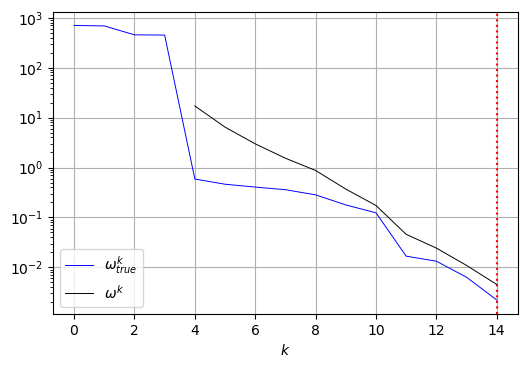

In [24]:
ob.plot_true_rel_gap_uk(lk = -np.array(prob.upper_bnd), uk = -np.array(prob.lower_bnd), h_true = h_cvx)